# Content translation from English to Thai 

## The change of source and target articles after the translation

# Table of contents
1. [Objectives](#Objectives)
2. [Methods](#Methods)
3. [Initialization](#Initialization)
4. [Data exploration](#Dataexplo)
5. [Analyses](#Analyses)

   5.1 [Quantitative](#Quantitative)

      + [The source article edit amount since it got translated](#sourceEdit)
     
      + [The target article edit amount since the translation](#targetEdit)
        
      + [The source article cumulative size change since it got translated](#sourceSizeChange)
      
      + [The target article cumulative size change since the translation](#targetSizeChange)
      
      + [Quantitative test discuession](#Quantitativedis)
      
   5.2 [Qualitative](#Qualitative)
   
      + [Source article with the highest edit amount since it got translated](#Highse)
      
      + [Target article with the highest edit amount since the translation](#Highte)
      
      + [Source article with the highest cumulative size change since it got translated](#Highsc)
      
      + [Target article with the highest cumulative size change since it the translation](#Hightc)
      
      + [Qualitative test discuession](#Qualitativedis)
      
6. [Conclusion](#Conclusion)
7. [Opportunities for furture study](#Opportunities)
8. [References](#References)
9. [Others data explore](#Others)

## Objectives <a name="Objectives"></a>
+ Count edit times and size changed of articles since the translation
+ Find the content that change after the translation
+ Find the difference and similarity in the current version of source and target articles after both articles were edited

## Methods <a name="Methods"></a>
+ Quantitative
    + Use revisions API to collect source edit amount since the translation, target edit amount, source size change since the translation, and target size change since the translation
    + Create Pandas dataframe to collect and explore the result
    + Use tables and graphs to compare the data
+ Qualitative
    + The articles that have highest edit amount and the largest cumulative size change since the translation were chosen to do qualitative analysis.
    + Analyze the the edit content of source and target articles since the translation by using compare selected revisions on history page on Wikipedia and see the change and the detail of the change since the translation date. 

## Initialization  <a name="Initialization"></a>

follow steps according to https://paws-public.wmflabs.org/paws-public/User:Isaac_(WMF)/Content%20Translation%20Example.ipynb#Alternative-view-of-the-data-via-Pandas

In [1]:
#imports
import gzip
import json
import re

import mwapi
import pandas as pd

import numpy as np
from numpy import nan
from scipy import stats

import matplotlib.pyplot as plt

In [2]:
# get session for English articles
session = mwapi.Session(host='https://en.wikipedia.org',
                        user_agent='mwapi (python) -- outreachy content translation')

In [3]:
# get session for Thai articles
session_th = mwapi.Session(host='https://th.wikipedia.org',
                        user_agent='mwapi (python) -- outreachy content translation')

In [4]:
# articles translated from English -> Thai
parameters = {'action':'query',
              'format':'json',
              'list':'cxpublishedtranslations',
              'from':'en',
              'to':'th',
              'limit':500,
              'offset':2500}

# Data exploration <a name="Dataexplo"></a>

In [5]:
res = session.get(parameters)

In [6]:
df = pd.DataFrame(res['result']['translations'])
df.head(10)

,publishedDate,sourceLanguage,sourceRevisionId,sourceTitle,sourceURL,stats,targetLanguage,targetRevisionId,targetTitle,targetURL,translationId
0,20180616090318,en,846093806,Sonia Scurfield,//en.wikipedia.org/wiki/Sonia Scurfield,"{'any': 0.41319606925597, 'human': 0.313991576...",th,7678509,ซอนย่า สเกอร์ฟิลด์,//th.wikipedia.org/wiki/ซอนย่า สเกอร์ฟิลด์,491563
1,20180616092527,en,844984088,Andrew Massey (conductor),//en.wikipedia.org/wiki/Andrew Massey (conductor),"{'any': 0.92383292383292, 'human': 0.883292383...",th,7678529,แอนดี แมสซีย์ (วาทยากร),//th.wikipedia.org/wiki/แอนดี แมสซีย์ (วาทยากร),491571
2,20180616093431,en,845176394,Sam Moore (publisher),//en.wikipedia.org/wiki/Sam Moore (publisher),"{'any': 0.42849223946785, 'human': 0.428492239...",th,7678540,ซัม มัวร์ (ผู้เผยแพร่),//th.wikipedia.org/wiki/ซัม มัวร์ (ผู้เผยแพร่),491580
3,20180901233542,en,845016481,André Desvages,//en.wikipedia.org/wiki/André Desvages,"{'any': 0.59139784946237, 'human': 0.479569892...",th,7678579,อ็องเดร เดอวาก,//th.wikipedia.org/wiki/อ็องเดร เดอวาก,491589
4,20180616095938,en,845590955,Johnnie Keyes,//en.wikipedia.org/wiki/Johnnie Keyes,"{'any': 0.86713995943205, 'human': 0.735294117...",th,7678608,จอห์นนี่ คียส์,//th.wikipedia.org/wiki/จอห์นนี่ คียส์,491591
5,20180901233542,en,844509740,Robert Forhan,//en.wikipedia.org/wiki/Robert Forhan,"{'any': 0.39078498293515, 'human': 0.322525597...",th,7678635,โรเบิร์ต ฟอร์แฮน,//th.wikipedia.org/wiki/โรเบิร์ต ฟอร์แฮน,491595
6,20180901233521,en,829989743,Amand Dalem,//en.wikipedia.org/wiki/Amand Dalem,"{'any': 0.96084337349398, 'human': 0.960843373...",th,7678839,อามันด์ ดาเลม,//th.wikipedia.org/wiki/อามันด์ ดาเลม,491657
7,20180616124609,en,823655681,Édouard Ferrand,//en.wikipedia.org/wiki/Édouard Ferrand,"{'any': 0.96287703016241, 'human': 0.962877030...",th,7678856,เอดูอาร์ แฟร็อง,//th.wikipedia.org/wiki/เอดูอาร์ แฟร็อง,491660
8,20180901233519,en,823520159,Zeng Jinyan,//en.wikipedia.org/wiki/Zeng Jinyan,"{'any': 0.30705190989226, 'human': 0.215964740...",th,7678890,เจิ้ง จินย่าน,//th.wikipedia.org/wiki/เจิ้ง จินย่าน,491672
9,20180616232534,en,845477568,Jean-Baptiste Kim,//en.wikipedia.org/wiki/Jean-Baptiste Kim,"{'any': 0.617903930131, 'human': 0.61790393013...",th,7679569,จีน-บาติสต์ คิม,//th.wikipedia.org/wiki/จีน-บาติสต์ คิม,491909


#### Explore on stats column

In [7]:
df_stats = df['stats'].apply(pd.Series)
df_stats.head()

,any,human,mt,mtSectionsCount,translatedSectionsCount
0,0.413196,0.313992,0.099204,1.0,NaN
1,0.923833,0.883292,0.040541,1.0,NaN
2,0.428492,0.428492,0.000000,0.0,NaN
3,0.591398,0.479570,0.111828,1.0,NaN
4,0.867140,0.735294,0.131846,1.0,NaN


In [8]:
df_stats.describe()

,any,human,mt,mtSectionsCount,translatedSectionsCount
count,500.000000,500.000000,500.000000,500.000000,4.000000
mean,0.724505,0.628018,0.096488,1.532000,20.750000
std,0.569838,0.583701,0.240336,5.035045,17.783419
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,0.352576,0.239826,0.000000,0.000000,11.250000
50%,0.574587,0.440298,0.002692,1.000000,17.500000
75%,0.894474,0.834261,0.062125,1.000000,27.000000
max,4.302449,4.302449,2.862802,64.000000,45.000000


In [9]:
# Article that has total translation percentage higher than 2.5
df_stats[df_stats['any'] > 2.5]

,any,human,mt,mtSectionsCount,translatedSectionsCount
321,3.530609,3.333557,0.197051,1.0,NaN
378,2.788609,2.788609,0.000000,0.0,NaN
379,2.508139,2.506511,0.001628,1.0,NaN
438,2.906087,0.043285,2.862802,1.0,NaN
440,2.948431,2.948431,0.000000,0.0,NaN
464,2.911345,2.852139,0.059206,1.0,NaN
481,2.570600,2.570600,0.000000,0.0,NaN
485,4.302449,4.302449,0.000000,0.0,NaN


In [10]:
# Article that has machine translation percentage higher than 1
df_stats[df_stats['mt'] > 1]

,any,human,mt,mtSectionsCount,translatedSectionsCount
46,1.090814,0.000000,1.090814,8.0,NaN
419,2.197262,0.060021,2.137241,1.0,NaN
438,2.906087,0.043285,2.862802,1.0,NaN


**Note1:** It can be seen that some articles has `any` (total translation percentage) and `mt` (machine translation percentage) higher than 1.
Which [Outreachy mentor explained that the number base on word count.](https://phabricator.wikimedia.org/T218003#5029680) So it is possible that word in source article is higher than translated article, resulted in `any` and `mt` higher than 1.

#### Get corresponding parallel translation

In [11]:
#Download dump to access all translated articles
json_str = ""
with gzip.open('cx-corpora.en2th.text.json.gz', 'rt', encoding='utf-8') as fin:
    for line in fin:
        json_str += line.strip()
# remove repetitive commas
json_str = re.sub(',{2,}', ',', json_str)
parallel_corpus = json.loads(json_str)

In [12]:
print("Descriptive statistics:")
print("{0} translated sections.".format(len(parallel_corpus)))
print("{0} translated articles.".format(len(set(sec['id'].split('/')[0] for sec in parallel_corpus))))

Descriptive statistics:
18281 translated sections.
2669 translated articles.


**Note2:** according to [statistic on Thai Wikipedia](https://th.wikipedia.org/w/index.php?title=%E0%B8%9E%E0%B8%B4%E0%B9%80%E0%B8%A8%E0%B8%A9:%E0%B8%AA%E0%B8%96%E0%B8%B4%E0%B8%95%E0%B8%B4&action=raw), a total articles on Thai Wikipedia are 130,431 articles (The statistic data in 20 March 2019).

#### parallel translation data explore

In [13]:
mt_counts = {}
for sec in parallel_corpus:
    if sec['mt']:
        service = sec['mt']['engine']
        mt_counts[service] = mt_counts.get(service, 0) + 1
    else:
        mt_counts['no-mt'] = mt_counts.get('no-mt', 0) + 1
print("Machine translation services used: {0}".format(mt_counts))

Machine translation services used: {'no-mt': 16474, 'Yandex': 1642, 'Google': 165}


# Analyses <a name="Analyses"></a>

## Quantitative <a name="Quantitative"></a>

In [14]:
#create emty dict for adding data
edit_n_size_df = {'sourceTitle':[],
                            'sourceRevisionId':[],
                            'targetTitle':[],
                            'targetRevisionId':[],
                            'dateCreatingTarget':[],
                            'sourceEdit':[],
                            'targetEdit':[],
                            'sourceSizeChange':[],
                            'targetSizeChange':[]
                            }

#loop through 500 articles
for i in range(0,500):
    source_title = df.loc[i, 'sourceTitle']
    source_revid = df.loc[i, 'sourceRevisionId']
    target_title = df.loc[i, 'targetTitle']
    tid = df.loc[i,'targetRevisionId']
    
    edit_n_size_df['sourceTitle'].append(source_title)
    edit_n_size_df['sourceRevisionId'].append(source_revid)
    edit_n_size_df['targetTitle'].append(target_title)
    edit_n_size_df['targetRevisionId'].append(tid)
    
    # create paremeters for collect revision data from source articles
    revision_parameters_s = {
        "action": "query",
        "prop": "revisions",
        "titles": source_title,
        "rvprop": "timestamp|size|comment",
        "rvlimit": 500,    # no more than 500 allowed
        "rvstartid": source_revid,
        "rvslots": "main",
        "formatversion": "2",
        "format": "json",
        "rvdir": "newer",    # from oldest to newer
        "redirects": True
        }
    # revision data from source articles
    source_revisions = session.get(revision_parameters_s)
    
    # create paremeters for collect revision data from target articles
    revision_parameters_t = {
        "action": "query",
        "prop": "revisions",
        "titles": target_title,
        "rvprop": "timestamp|size|comment",
        "rvlimit": 500,    # no more than 500 allowed
        "rvstartid": tid,
        "rvslots": "main",
        "formatversion": "2",
        "format": "json",
        "rvdir": "newer",    # from oldest to newer
        "redirects": True
        }
    # revision data from target articles
    target_revisions = session_th.get(revision_parameters_t)
    
    # missing data
    if (target_title == "") or (('revisions' in target_revisions['query']['pages'][0])==False) or (( 'moved page' in source_revisions['query']['pages'][0]['revisions'][0]['comment']) == True) or (('missing' in target_revisions['query']['pages'][0]) == True):
        edit_n_size_df['dateCreatingTarget'].append(np.nan)
        edit_n_size_df['sourceEdit'].append(np.nan)
        edit_n_size_df['targetEdit'].append(np.nan)
        edit_n_size_df['sourceSizeChange'].append(np.nan)
        edit_n_size_df['targetSizeChange'].append(np.nan)

    else:
    
        # collect date of creating target article
        date_c_target = target_revisions['query']['pages'][0]['revisions'][0]['timestamp']
    
        # count source edit amount since it got translated
        source_edit_all = len(source_revisions['query']['pages'][0]['revisions'])    # all edit
        source_edit = 0
        for j in range(source_edit_all):
            if source_revisions['query']['pages'][0]['revisions'][j]['timestamp'] >= date_c_target:    # source edit date is higher or equal to target created date
                source_edit += 1
   
        # count target edit amount
        target_edit = len(target_revisions['query']['pages'][0]['revisions'])
    
        # find cumulative size change of source article since it got translated. Calculated by find size different between edit and sum those size different
        source_size = 0
        for r in range(source_edit):    # source_edit is also a row number of the oldest article after it got translated
            diff_size = source_revisions['query']['pages'][0]['revisions'][r+1]['size'] - source_revisions['query']['pages'][0]['revisions'][r]['size'] # newer size  - older size
            source_size += abs(diff_size) # wants to see the sum of the size that change, either decrease or increase of the size don't matter. So I put absolute there
        
        # find cumulative target size change
        target_size = 0
        for r in range(target_edit-1):    # target_edit is also a row number of target article last edit 
            diff_size = target_revisions['query']['pages'][0]['revisions'][r+1]['size'] - target_revisions['query']['pages'][0]['revisions'][r]['size'] # newer size  - older size
            target_size += abs(diff_size) # wants to see the sum of the size that change, either decrease or increase of the size don't matter. So I put absolute there
    
        # append data to dictionary
        edit_n_size_df['dateCreatingTarget'].append(date_c_target)
        edit_n_size_df['sourceEdit'].append(source_edit)
        edit_n_size_df['targetEdit'].append(target_edit)
        edit_n_size_df['sourceSizeChange'].append(source_size)
        edit_n_size_df['targetSizeChange'].append(target_size)

`dateCreatingTarget` is the date and time when the article got translated

`sourceEdit` is the source article edit amount since it got translated (amount of the edit that happened after `dateCreatingTarget`)

`targetEdit` is  the target article edit amount since the translation

`sourceSizeChange` is the source article cumulative size change since it got translated (either removed or added has been sum as positive value)

`targetSizeChange` is  the target article cumulative size change since it the translation (either removed or added has been sum as positive value)

**Note3:** The for loop to calculate `source_size` in the previous code range is `range(source_edit)` without minus 1 on source_edit. However, in the for loop to calculate `target_size`, the range is `range(target_edit-1)`.

To count each row, the for loop is needed to loop over the row of article since the translation date by specify it in range. The value on `source_edit` and `target_edit` are not only indicate the edit amount of article but also indicate the row of article since the translation date.

Both of the range in for loop are difference because the `source_size` and `target_size` are the size change since it got translated. However, the source article which got translated is the version *before* the translation date, while for the target article the version is exactly the same as date created. Therefore, the range of `target_size` in for loop should be less than the range of `source_size` by 1.

the range(source_edit+1) and range(target_edit) can be used too, but the subsetting for calculating diff_size need to be change.

In [15]:
edit_n_size_pd = pd.DataFrame(edit_n_size_df)

In [16]:
edit_n_size_pd.head(5)

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
0,Sonia Scurfield,846093806,ซอนย่า สเกอร์ฟิลด์,7678509,2018-06-16T09:03:18Z,3.0,2.0,58.0,81.0
1,Andrew Massey (conductor),844984088,แอนดี แมสซีย์ (วาทยากร),7678529,2018-06-16T09:25:27Z,10.0,2.0,364.0,4.0
2,Sam Moore (publisher),845176394,ซัม มัวร์ (ผู้เผยแพร่),7678540,2018-06-16T09:34:31Z,1.0,3.0,10.0,85.0
3,André Desvages,845016481,อ็องเดร เดอวาก,7678579,2018-06-16T09:47:32Z,2.0,3.0,184.0,127.0
4,Johnnie Keyes,845590955,จอห์นนี่ คียส์,7678608,2018-06-16T09:59:38Z,10.0,3.0,434.0,340.0


In [17]:
edit_n_size_pd.tail(5)

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
495,Michael Eilberg,874054976,ไมเคิล จอร์จ ไอล์เบิร์ก,8050199,2019-01-06T03:45:58Z,0.0,3.0,0.0,83.0
496,Frank Errington,869002862,แฟรงก์ เออร์ริงตัน,8050214,2019-01-06T03:55:21Z,0.0,3.0,0.0,321.0
497,Abigail Edmonds,833951699,อบิเกล เอ็ดมอนดส์,8050220,2019-01-06T03:58:51Z,0.0,2.0,0.0,2.0
498,Barry Lillywhite,871774084,แบร์รี ลิลลิไวไฮต์,8050228,2019-01-06T04:02:16Z,0.0,3.0,0.0,113.0
499,Blake Nordstrom,877051179,เบลก นอร์ดสตรอม,8050883,2019-01-06T10:20:26Z,37.0,2.0,9024.0,2.0


In [18]:
#data describe
edit_n_size_pd.describe()

,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
count,477.000000,477.000000,477.000000,477.000000
mean,8.433962,3.480084,2412.880503,741.364780
std,33.839499,7.222319,24880.276453,3159.728396
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,1.000000,2.000000,20.000000,25.000000
75%,4.000000,3.000000,276.000000,144.000000
max,499.000000,121.000000,528213.000000,36104.000000


### The source article edit amount since it got translated (sourceEdit) <a name="sourceEdit"></a>

In [19]:
edit_n_size_pd.nlargest(5, ['sourceEdit'])

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
376,Deaths in 2019,876398709,บุคคลที่เสียชีวิตในปี พ.ศ. 2562,8042701,2019-01-02T03:20:02Z,499.0,53.0,60613.0,9057.0
24,MacOS Mojave,847186226,macOS Mojave,7693429,2018-06-24T14:20:58Z,302.0,9.0,21320.0,546.0
291,"New Caledonian independence referendum, 2018",858388704,การลงประชามติเอกราชนิวแคลิโดเนีย ค.ศ. 2018,7849015,2018-09-16T12:50:56Z,226.0,7.0,27692.0,2883.0
315,Sebastian Stan,860325883,เซบาสเตียน สแตน,7875543,2018-09-30T07:08:10Z,200.0,15.0,16418.0,4445.0
327,Goblin Slayer,866058978,ก็อบลิน สเลเยอร์,7926159,2018-10-28T09:50:59Z,152.0,11.0,78860.0,5998.0


**Note4:**  <a name="Note4"></a> 
`rvlimit` in paremeters for collect revision data from source articles is 500. However, the maximum showed in `sourceEdit` is 499 instead of 500 because `rvdir` is set to "newer" which mean it was listed from the oldest to the newer articles. In Deaths in 2019 article, the oldest version of article was created before the translation date. 

Since this count the edit *after* the translation date only, it should be keeping in mind that it is possible that some articles' edit data beyond `rvlimit` that cannot be collected are higher than edit amount after translation date of Deaths in 2019 article. Example situation is if 200 edited occured before the translation date and 1000 edited after the translation date, the data collected will be only first 500 which mean `sourceEdit` of this article will be 300, not 1000)

(array([444.,  16.,   4.,   3.,   5.,   0.,   1.,   0.,   1.,   1.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,  24.95,  49.9 ,  74.85,  99.8 , 124.75, 149.7 , 174.65,
        199.6 , 224.55, 249.5 , 274.45, 299.4 , 324.35, 349.3 , 374.25,
        399.2 , 424.15, 449.1 , 474.05, 499.  ]),
 <a list of 20 Patch objects>)

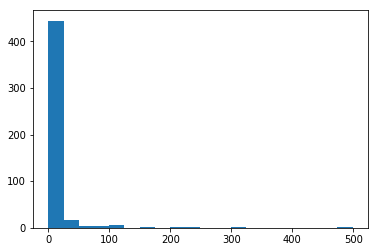

In [20]:
# Histogram of sourceEdit
plt.hist(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])], bins =20)   # exclude NaN

In [21]:
total_not_nan_se = len(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])])
stat_mode_se = stats.mode(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])])[0][0]
mode_freq_se = stats.mode(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])])[1][0]

print('The total articles that is not NaN is '+str(total_not_nan_se))
print('Most frequent edit amount per article is '+str(stat_mode_se)+' time.')
print('The number of articles that have been edited '+str(stat_mode_se)+' time is '+str(mode_freq_se))
print('The number of articles that have been edited 1 time is '+str(len(edit_n_size_pd[edit_n_size_pd['sourceEdit']==1] )))

The total articles that is not NaN is 477
Most frequent edit amount per article is 0.0 time.
The number of articles that have been edited 0.0 time is 192
The number of articles that have been edited 1 time is 87


###  The target article edit amount since the translation (targetEdit) <a name="targetEdit"></a>

In [22]:
edit_n_size_pd.nlargest(5, 'targetEdit')

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
324,List of mango cultivars,861744980,รายชื่อพันธุ์มะม่วง,7893244,2018-10-09T09:24:43Z,11.0,121.0,2203.0,6043.0
376,Deaths in 2019,876398709,บุคคลที่เสียชีวิตในปี พ.ศ. 2562,8042701,2019-01-02T03:20:02Z,499.0,53.0,60613.0,9057.0
61,Find Your Way,853018077,ไฟด์ยัวร์เวย์,7777929,2018-08-12T06:03:49Z,2.0,51.0,93.0,4567.0
345,Isan Pattaya,835833752,สโมสรฟุตบอลอีสาน ดีบีชออร่า พัทยา,7966349,2018-11-19T15:30:55Z,14.0,36.0,2164.0,26704.0
67,Under My Skin (Gabrielle album),856381641,อันเดอร์มายสกิน,7803885,2018-08-26T03:00:57Z,14.0,31.0,2698.0,5310.0


(array([439.,  25.,   3.,   3.,   2.,   2.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.,   7.,  13.,  19.,  25.,  31.,  37.,  43.,  49.,  55.,  61.,
         67.,  73.,  79.,  85.,  91.,  97., 103., 109., 115., 121.]),
 <a list of 20 Patch objects>)

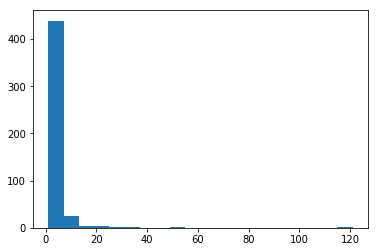

In [23]:
# Histogram of targetEdit
plt.hist(edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])], bins =20)   # exclude NaN

In [24]:
total_not_nan_te = len(edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])])
stat_mode_te = stats.mode(edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])])[0][0]
mode_freq_te = stats.mode(edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])])[1][0]

print('The total articles that is not NaN is '+str(total_not_nan_te))
print('Most frequent edit amount per article is '+str(stat_mode_te)+' time.')
print('The number of articles that have been edited '+str(stat_mode_te)+' time is '+str(mode_freq_te))
print('The number of articles that have been edited 0 time is '+str(len(edit_n_size_pd[edit_n_size_pd['sourceEdit']==0] )))

The total articles that is not NaN is 477
Most frequent edit amount per article is 1.0 time.
The number of articles that have been edited 1.0 time is 139
The number of articles that have been edited 0 time is 192


### The source article cumulative size change since it got translated (sourceSizeChange) <a name="sourceSizeChange"></a>

In [25]:
edit_n_size_pd.nlargest(5, 'sourceSizeChange')

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
424,Hindenburg disaster,875776290,วินาศภัยไฮเดลเบิร์ก,8047957,2019-01-05T01:47:44Z,68.0,3.0,528213.0,125.0
327,Goblin Slayer,866058978,ก็อบลิน สเลเยอร์,7926159,2018-10-28T09:50:59Z,152.0,11.0,78860.0,5998.0
376,Deaths in 2019,876398709,บุคคลที่เสียชีวิตในปี พ.ศ. 2562,8042701,2019-01-02T03:20:02Z,499.0,53.0,60613.0,9057.0
34,List of Seventeen concert tours,849101456,รายชื่อทัวร์คอนเสิร์ตและแฟนมีตติงของเซเวนทีน,7715180,2018-07-07T07:05:09Z,82.0,19.0,44978.0,36104.0
18,Treaty of Hudaybiyyah,846946779,สนธิสัญญาฮุดัยบิยะฮ์,7723118,2018-07-11T13:59:17Z,81.0,1.0,39781.0,0.0


(array([471.,   3.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([     0.  ,  26410.65,  52821.3 ,  79231.95, 105642.6 , 132053.25,
        158463.9 , 184874.55, 211285.2 , 237695.85, 264106.5 , 290517.15,
        316927.8 , 343338.45, 369749.1 , 396159.75, 422570.4 , 448981.05,
        475391.7 , 501802.35, 528213.  ]),
 <a list of 20 Patch objects>)

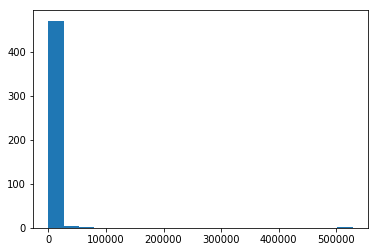

In [26]:
# Histogram of sourceSizeChange
plt.hist(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])], bins =20)   # exclude NaN

In [27]:
total_not_nan_sc = len(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])])
stat_mode_sc = stats.mode(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])])[0][0]
mode_freq_sc = stats.mode(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])])[1][0]
median_sc = np.median(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])])

print('The total articles that is not NaN is '+str(total_not_nan_sc))
print('Most frequent size change per article is '+str(stat_mode_sc)+' byte.')
print('The number of articles that have total size change equal to '+str(stat_mode_sc)+'byte is '+str(mode_freq_sc))
print('The median of size chage is '+str(median_sc )+' bytes.')

The total articles that is not NaN is 477
Most frequent size change per article is 0.0 byte.
The number of articles that have total size change equal to 0.0byte is 201
The median of size chage is 20.0 bytes.


###  The target article cumulative size change since it the translation (targetSizeChange) <a name="targetSizeChange"></a>

In [28]:
edit_n_size_pd.nlargest(5, 'targetSizeChange')

,sourceTitle,sourceRevisionId,targetTitle,targetRevisionId,dateCreatingTarget,sourceEdit,targetEdit,sourceSizeChange,targetSizeChange
34,List of Seventeen concert tours,849101456,รายชื่อทัวร์คอนเสิร์ตและแฟนมีตติงของเซเวนทีน,7715180,2018-07-07T07:05:09Z,82.0,19.0,44978.0,36104.0
352,List of legislatures by number of members,869603280,รายชื่อสภานิติบัญญัติแห่งชาติตามจำนวนสมาชิก,7982431,2018-11-28T11:46:26Z,3.0,5.0,123.0,29282.0
345,Isan Pattaya,835833752,สโมสรฟุตบอลอีสาน ดีบีชออร่า พัทยา,7966349,2018-11-19T15:30:55Z,14.0,36.0,2164.0,26704.0
354,List of countries by body mass index,870854912,รายชื่อประเทศเรียงตามดัชนีมวลกาย,7982462,2018-11-28T12:13:27Z,36.0,8.0,898.0,22626.0
92,List of elevation extremes by country,853994442,รายชื่อประเทศเรียงตามระดับความสูง,7826515,2018-09-06T13:30:46Z,22.0,7.0,1374.0,19504.0


(array([441.,  12.,   7.,   4.,   3.,   4.,   0.,   0.,   0.,   1.,   1.,
          0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   1.]),
 array([    0. ,  1805.2,  3610.4,  5415.6,  7220.8,  9026. , 10831.2,
        12636.4, 14441.6, 16246.8, 18052. , 19857.2, 21662.4, 23467.6,
        25272.8, 27078. , 28883.2, 30688.4, 32493.6, 34298.8, 36104. ]),
 <a list of 20 Patch objects>)

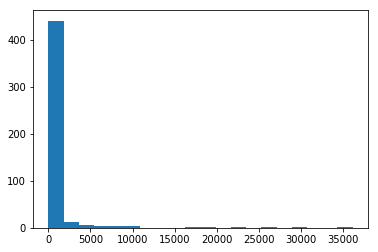

In [29]:
# Histogram of targetSizeChange
plt.hist(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])], bins =20)   # exclude NaN

In [30]:
total_not_nan_tc = len(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])
stat_mode_tc = stats.mode(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])[0][0]
mode_freq_tc = stats.mode(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])[1][0]
median_tc = np.median(edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])

print('The total articles that is not NaN is '+str(total_not_nan_tc))
print('Most frequent size change per article is '+str(stat_mode_tc)+' byte.')
print('The number of articles that have total size change equal to '+str(stat_mode_tc)+' byte is '+str(mode_freq_tc))
print('The median of size chage is '+str(median_tc)+' bytes.')

The total articles that is not NaN is 477
Most frequent size change per article is 0.0 byte.
The number of articles that have total size change equal to 0.0 byte is 152
The median of size chage is 25.0 bytes.


#### The graph between edit and size change (The graphs present specific x and y axis)

Text(0.5,1,'targetEdit vs targetSizeChange')

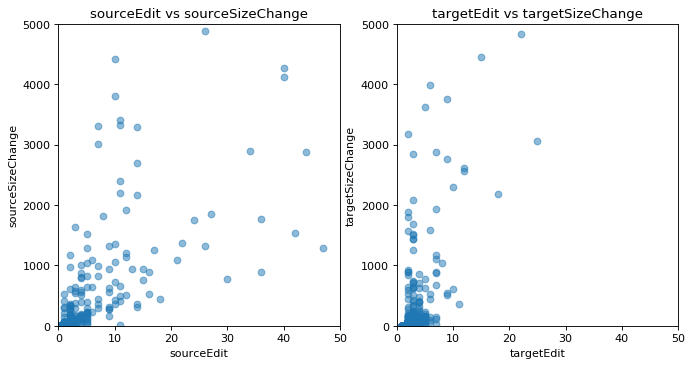

In [31]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=80)

plt.subplot(1,2,1)
plt.scatter(edit_n_size_pd['sourceEdit'],edit_n_size_pd['sourceSizeChange'], alpha = 0.5)
plt.xlim(0,50)
plt.ylim(0, 5000)
plt.xlabel('sourceEdit')
plt.ylabel('sourceSizeChange')
plt.title('sourceEdit vs sourceSizeChange')

plt.subplot(1,2,2)
plt.scatter(edit_n_size_pd['targetEdit'],edit_n_size_pd['targetSizeChange'],alpha = 0.5)
plt.xlim(0,50)
plt.ylim(0, 5000)
plt.xlabel('targetEdit')
plt.ylabel('targetSizeChange')
plt.title('targetEdit vs targetSizeChange')

In [32]:
# Pearson correlation coefficient of  sourceEdit vs sourceSizeChange
sesc_r = np.corrcoef(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])],edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])])[0,1]
print('Pearson correlation coefficient of sourceEdit vs sourceSizeChange is '+str(sesc_r))

# Pearson correlation coefficient of  targetEdit vs targetSizeChange
tetc_r = np.corrcoef(edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])],edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])[0,1]
print('Pearson correlation coefficient of targetEdit vs targetSizeChange is '+ str(tetc_r))

Pearson correlation coefficient of sourceEdit vs sourceSizeChange is 0.26901292439207136
Pearson correlation coefficient of targetEdit vs targetSizeChange is 0.39114397083006003


#### The graph between source edit and target edit, and between source size change and target size change (The graphs present specific x and y axis)

Text(0.5,1,'sourceSizeChange vs targetSizeChange')

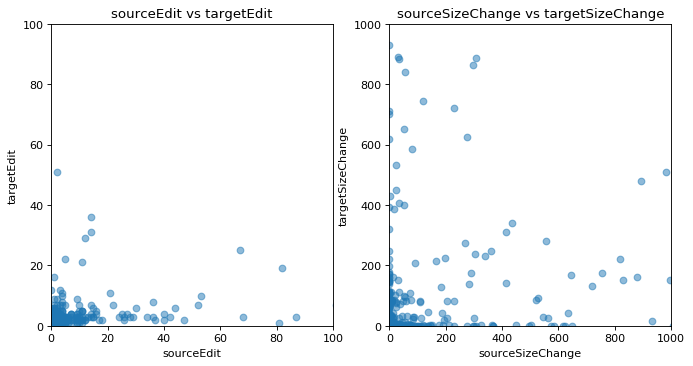

In [33]:
figure(num=None, figsize=(10, 5), dpi=80)

plt.subplot(1,2,1)
plt.scatter(edit_n_size_pd['sourceEdit'],edit_n_size_pd['targetEdit'], alpha = 0.5)
plt.xlim(0,100)
plt.ylim(0, 100)
plt.xlabel('sourceEdit')
plt.ylabel('targetEdit')
plt.title('sourceEdit vs targetEdit')

plt.subplot(1,2,2)
plt.scatter(edit_n_size_pd['sourceSizeChange'],edit_n_size_pd['targetSizeChange'], alpha = 0.5)
plt.xlim(0,1000)
plt.ylim(0, 1000)
plt.xlabel('sourceSizeChange')
plt.ylabel('targetSizeChange')
plt.title('sourceSizeChange vs targetSizeChange')

In [34]:
# Pearson correlation coefficient of  sorceEdit vs targetEdit
sesc_r = np.corrcoef(edit_n_size_pd['sourceEdit'][~np.isnan(edit_n_size_pd['sourceEdit'])],edit_n_size_pd['targetEdit'][~np.isnan(edit_n_size_pd['targetEdit'])])[0,1]
print('Pearson correlation coefficient of sorceEdit vs targetEdit is '+str(sesc_r))

# Pearson correlation coefficient of  sourceSizeChange vs targetSizeChange
tetc_r = np.corrcoef(edit_n_size_pd['sourceSizeChange'][~np.isnan(edit_n_size_pd['sourceSizeChange'])],edit_n_size_pd['targetSizeChange'][~np.isnan(edit_n_size_pd['targetSizeChange'])])[0,1]
print('Pearson correlation coefficient of sourceSizeChange vs targetSizeChange is '+ str(tetc_r))

Pearson correlation coefficient of sorceEdit vs targetEdit is 0.3340944454072099
Pearson correlation coefficient of sourceSizeChange vs targetSizeChange is 0.06362270170646042


### Quantitative test discuession <a name="Quantitativedis"></a>
From the data describe table, there are 477 articles that have no missing data. The maximum source edit amount since translation (`sourceEdit`) is 499 times (also see [note4](#Note4)), the maximum target edit amount since translation (`targetEdit`) is 121 times.  For the size change, the largest cumulative size change (either add or remove from article was counted) of source article is 526087 bytes and for target article is 36104 bytes. Those articles were looked into the change details in qualitative part.

It can be seen from all histogram graph that most of the number of edit or change size are concentrated on the lower number. The majority of edit amount on source articles and target articles is either 0 or 1 time. The most frequent size change per article on source article size change and target article size change is 0 byte. Therefore, after the translation, most articles have little to no change.

According to the graph between edit amount and cumulative size change,  the trend couldn't be identify. The Pearson correlation coefficient between source edit amount and source cumulative size change, and between target edit amount and target cumulative size change are low (0.2666 and 0.4130 respectively). It is possible that articles that have high edit amount but low size chage because they edited the minor misspelling or grammar, while the articles that have large size change but low edit amount may happen because new data were added to the articles at the same time.

If the correlation between source edit amount and target edit amount or between source cumulative size change and target cumulative size change can be identify, then it may give an explaination whether the edit in source articles resulted in the edit in target articles or not. However, the trend between source edit and target edit, and between source size change and target size change cannot be identify. To investigate more detail in this topic, if the minor edit data are removed and only significant edit left, it could reveal the relationship between variables which should be studied further.

## Qualitative <a name="Qualitative"></a>

The articles that have highest `sourceEdit`, `targetEdit`, `sourceSizeChange`, and `targetSizeChange` were chosen to do qualitative analysis

### Source article with the highest edit amount since it got translated (sourceEdit) <a name="Highse"></a>
Reminding that `sourceEdit` was count from the day that the source article got translated into Thai ariticle (from `dateCreatingTarget`), since the objective is to see the difference and similarity in both articles after translation.

Make sense that Deaths in 2019 have high edit because 2019 is this current year.

In [35]:
pd.options.display.max_colwidth = 100    # to view long URL
df[['sourceURL','targetURL']][df['sourceTitle'] == 'Deaths in 2019']

,sourceURL,targetURL
376,//en.wikipedia.org/wiki/Deaths in 2019,//th.wikipedia.org/wiki/บุคคลที่เสียชีวิตในปี พ.ศ. 2562


From the quantitative part, the target article that has the highest edit amount since translation date is **"Deaths in 2019"**. The source article (English) has cumulative size change 44978 bytes. The target article (Thai) has been edit 53 times with cumulative size change 36104 bytes.

Since this is the article about on going year, both article still update over time. Not all of edit in English article were updated in Thai article. The length of both article are different. English article was splited by date and month, while Thai article was split by month and order by date. Thai well known who death in 2019 were added in Thai article, but only one Thai well known was added in English article.
Interesting that the Deaths in 2019 Thai article was created by translating from English article, while [Deaths in 2018](https://th.wikipedia.org/wiki/%E0%B8%9A%E0%B8%B8%E0%B8%84%E0%B8%84%E0%B8%A5%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B9%80%E0%B8%AA%E0%B8%B5%E0%B8%A2%E0%B8%8A%E0%B8%B5%E0%B8%A7%E0%B8%B4%E0%B8%95%E0%B9%83%E0%B8%99%E0%B8%9B%E0%B8%B5_%E0%B8%9E.%E0%B8%A8._2561) Thai article was not. Both English and Thai articles were edited by multiple editors.

The talk section on English article has a lot of discussion, FAQ and guideline. While Thai article has no activity.

### Target article with the highest edit amount since the translation (targetEdit) <a name="Highte"></a>

In [36]:
df[['sourceURL','targetURL']][df['sourceTitle'] == 'List of mango cultivars']

,sourceURL,targetURL
324,//en.wikipedia.org/wiki/List of mango cultivars,//th.wikipedia.org/wiki/รายชื่อพันธุ์มะม่วง


The target article that have highest edit amount is **List of mango cultivars** which have been edit for equal to 100 or more times with a cumulative size change 2203 bytes. While the source of this article was edited 11 times with a cumulative size change 5204 bytes.

At the transation ,all of the content in English got translate into Thai. No missing content was left untranslated. After the translation (since 18:17, 29 September 2018 which is the version of source article that got translated), there are some typo edited to the English article and added more cultivars such as Paige, Pickering, Pram Kai Mea, Rosa with some information. 

While Thai article only had minor edit. For example, changed transliterated country and cultivars names into Thai, changed links inside article from  English to Thai Wikipedia articles, added country name to sentence that had only state name (where in English article don't have country name in the same sentence). The cultivars that were added in English article was not added into Thai article.

Unlike English article that has multiple editors, in Thai article almost all change come from a single editor. Moreover, the Thai article got edited in a close time and had small change per edit, which is the reason of high target edited amount in this article.

There are discussion in the English article talk page about article pattern, data add, tag add. However, no talk create in 2018 and 2019. While talk page of Thai article has no activity.

### Source article with the highest cumulative size change since it got translated (sourceSizeChange) <a name="Highsc"></a>
Similar to `sourceEdit`, `sourceSizeChange` also count from the day that the source article got translated into Thai ariticle.

In [37]:
df[['sourceURL','targetURL']][df['sourceTitle'] == 'Hindenburg disaster']

,sourceURL,targetURL
424,//en.wikipedia.org/wiki/Hindenburg disaster,//th.wikipedia.org/wiki/วินาศภัยไฮเดลเบิร์ก


The source article that have highest cumulative size change is **Hindenburg disaster** which has 526087 bytes changed in 47 edits. While the target article has only 125 bytes changed in 3 edits.

Since 28 December 2018  (the version of source article that got translated), English article was edited to changed coding, fixed typo, fixed grammar,  added references and data with references, and change URL references in the article. The english article also has multiple revert edit. It was revert with  possible vandalism reason for 3 times. The talk page in English article has high contents. The talk after 28 December 2018 is about adding reference from a movie. This content on the talk also had been edit into the article.

Compare to English article, Thai article is not completed. Only the first paragraph got translated. The edits in Thai article just fixed typos and pattern. Which consistent with low edit amounts and low bytes changed on target ariticle. No talk on the talk page.

In addition, the English article of Hindenburg disaster has unregistered editing more than Deaths in 2019, List of mango cultivars, and List of Seventeen concert tours English articles.

### Target article with the highest cumulative size change since it the translation (targetSizeChange) <a name="Hightc"></a>

In [38]:
df[['sourceURL','targetURL']][df['sourceTitle'] == 'List of Seventeen concert tours']

,sourceURL,targetURL
34,//en.wikipedia.org/wiki/List of Seventeen concert tours,//th.wikipedia.org/wiki/รายชื่อทัวร์คอนเสิร์ตและแฟนมีตติงของเซเวนทีน


The target article that have highest cumulative size change is **List of Seventeen concert tours** which has 36104 bytes changed in 19 edits. While the source article has 44978 bytes changed in 82 edits.

Seventeen is an active boy band, therefore new contents are expected to be added. In english article more infomation was added since 6 July 2018 (the version of source article that got translated), for example, information about consert date, fanmeeting, and minor edited on typo.

When compare Thai article to the 6 July 2018 English ariticle, The translation to Thai was not completed. Only the first paragraph and the first table were translated. The later updated in Thai article was translations from English article from  6 July 2018 version. Therefore, no update made in English article was added into Thai article. Other than translation was a minor edited.

There were about two regular editors in English article while in Thai article was frequently edit by one person.

The talk page in English article has one discussion about deleting related article on 2017, no other article from 2018 and 2019. Thai talk page don't have any discussion.

### Qualitative test discuession <a name="Qualitativedis"></a>

According to the chosen articles, all four articles in English version (source article) had new updates since the translation. The edits in English articles were added new information and other minor edited such as changed coding, fixed grammar or added references. Thai articles also had minor edited, however, only one Thai article had more information updated which is "Deaths in 2019". The updated contents in "Deaths in 2019" ariticle still not the same as updated content in English article. This probably because the well known persons of two groups are different. English articles usually have multiple editors that edited the pages, but Thai articles have only one or two editors.

# Conclusion <a name="Conclusion"></a>
From total wikipedia 130,431 articles, 2670 articles was translated by using parallel translation. ( **TODO** check number again)
The total translated sections are 18300, most of the translation are from human (16474) the rest was translated from machine translation services (from Yandex 1642, from Google 183, from scratch 1). From 477 articles that not have missing data, most of the articles in source and target articles have small amount of edit amount and size change since the translation date. The maximum source edit amount since translation is 499 times, the maximum target edit amount since translation is 121 times, the largest cumulative size change of source article is 526087 bytes and for target article is 36104 bytes. The relationship between edit and size change, source edit and target edit, and between source size change and target size change cannot be identify. In qualitative analysis, all English articles that were explored have new content added since the translation date. While apart from minor edited, only one Thai article has new content. The other three articles have no new content added.
It is dificult to see the change in English articles when it get update since the translated date. The tool for editor which help compare both version may make it easier to see update contents which can be update into Thai articles.

## Opportunities for furture study <a name="Opportunities"></a>
+ Improve data analysis for content translation from English to Thai, such as explore more possibility to find correlation between source article edit and target article edit after translation (eg compare edit of active source articles to target articles, compare edit of recently large amount data added in source articles to target articles), explore more articles in qualitative analysis.
+ Use revisions API to collect comments to see what kind of words were used frequently in the talk page (this may possible to do word count in English only). Did the discussion in the talk page relate to edit amount? And did the content from discussion in source articles later be add in target articles?
+ Use revisions API to see which kind of article were edited by anonymous or regular users. Find if type of editors has any effect on edit amount.
+ Use revisions API to collect target size change per edit data. Then compare target articles that have small size edit (possibly typo fixed) to the target articles that have large size edit (possibly significant data changed)
+ Use page view API to compare page views between source and target articles and find if there are any relationship between page view and edit.

##  References <a name="References"></a>
https://paws-public.wmflabs.org/paws-public/User:Isaac_(WMF)/Content%20Translation%20Example.ipynb#Alternative-view-of-the-data-via-Pandas
https://phabricator.wikimedia.org/T218003#5029680
https://th.wikipedia.org/w/index.php?title=%E0%B8%9E%E0%B8%B4%E0%B9%80%E0%B8%A8%E0%B8%A9:%E0%B8%AA%E0%B8%96%E0%B8%B4%E0%B8%95%E0%B8%B4&action=raw
https://www.mediawiki.org/wiki/API:Revisions
https://www.mediawiki.org/wiki/Content_translation/Published_translations#List_of_published_source_and_target_titles

---

### Others data explore <a name="Others"></a>

+ Exploration of the out come of access parallel translation via dump: 
https://paws-public.wmflabs.org/paws-public/User:Supida_h/Data%20exploration%20on%20specific%20article%20via%20dump.ipynb


+ Data exploration on page views: 
https://paws-public.wmflabs.org/paws-public/User:Supida_h/Data%20exploration%20on%20page%20views.ipynb